In [1]:
# Jupyter Notebook with widget matplotlib plots
# %matplotlib notebook
# Jupyter Lab with widget matplotlib plots
%matplotlib widget 
# with Jupyter and Jupyter Lab but without widget matplotlib plots
# %matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%time
import sys
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import pyicon as pyic
import cartopy.crs as ccrs
import glob, os
import xarray as xr
import pandas as pd
import cartopy
# import seawater as sw

-----calc
sys glob os
numpy
netcdf
Done modules calc.
-----calc_xr
sys glob os
numpy
netcdf
xarray
Done modules calc.
-----tb
sys
json
numpy
scipy
netcdf datetime
matplotlib
mybreak
pnadas
xarray
done xarray
-----IconData
-----plotting
-----view
-----calc
-----calc_xr
-----tb
-----IconData
-----plotting
-----view
-----quickplots
-----quickplots
CPU times: user 1.75 s, sys: 1.34 s, total: 3.09 s
Wall time: 15 s


## Simulation and data settings

In [3]:
run = 'exp.ocean_era51h_zstar_r2b9_21249-DXB'
path_data = f'/work/bm1102/m211054/dyamond/zstar2/experiments/{run}/outdata/'
path_scratch = f'/mnt/lustre02/work/bm1102/m300602/proj_dw/{run}/'

In [4]:
mstr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [5]:
mfdset_kwargs = dict(combine='nested', concat_dim='time', 
                     data_vars='minimal', coords='minimal', compat='override', join='override',
                    )

In [6]:
fpath_fx = '/pool/data/ICON/oes/input/r0004/OceanOnly_IcosSymmetric_4932m_rotatedZ37d_modified_srtm30_1min/ZSTAR/R2B9L128_fx.nc'
fpath_ckdtree = '/home/mpim/m300602/work/icon/grids/r2b9_oce_r0004/ckdtree/rectgrids/r2b9_oce_r0004_res0.30_180W-180E_90S-90N.nc'

In [7]:
path_fig = f'/home/mpim/m300602/proj_dymwin/html/{run}/pics/'
thisscriptname = 'r2b9_dymwin_spinup'

In [8]:
do_save_fig = True
def save_fig(fpath, dpi=None):
    if do_save_fig:
        print(f'Saving {fpath}')
        plt.savefig(fpath, dpi=dpi)
    return

## Load grid

In [9]:
ds_ckdt = xr.open_dataset(fpath_ckdtree)
lon = ds_ckdt.lon.data
lat = ds_ckdt.lat.data

In [10]:
ds_fx = xr.open_mfdataset(fpath_fx, **mfdset_kwargs, chunks=dict(time=1, depth=1, depth_2=1))
depth = ds_fx.depth.compute().data

## Load data

In [13]:
%%time
fpatho = f'/mnt/lustre02/work/bm1102/m300602/proj_dw/en4/dymwin_bias_plots_interp_ref_r2b9.nc'
# if l_derive_data: # roughly 2min
if False:
# if True:
    fpathi = '/pool/data/ICDC/ocean/en4/DATA/analyses/EN.4.2.1.f.analysis.g10.20[1-2]???.nc'
    
    print('open mfdset')
    ds_tmp = xr.open_mfdataset(fpathi, **mfdset_kwargs)
    
    print('time ave')
#     dsi = xr.Dataset()
#     dsi['temperature'] = ds_tmp['temperature']
#     dsi['salinity'] = ds_tmp['salinity']
    ds_tmp = ds_tmp[['temperature', 'salinity']]
    ds_tmp = ds_tmp.sel(time=slice('2018-01-01', '2020-01-01'))
    ds_tmp = ds_tmp.groupby('time.month').mean().compute()
    
    print('shift grid')
    lon_tmp = ds_tmp.lon.data
    lat_tmp = ds_tmp.lat.data
    iw = (lon_tmp<180.).sum()
    lon_tmp[iw:] += -360.
    lon_tmp = np.concatenate([lon_tmp[iw:], lon_tmp[:iw]])
    varsi = ['temperature', 'salinity']
    varso = ['to_ref', 'so_ref']
    dsi = xr.Dataset()
    for varo, vari in zip(varso, varsi):
        da = xr.concat([ds_tmp[vari].isel(lon=slice(iw,None)), ds_tmp[vari].isel(lon=slice(None,iw))], dim='lon')
        da['lon'] = lon_tmp
        dsi[vari] = da
    dsi['temperature'] += -273.15

    print('interp')
    dso = xr.Dataset()
    for varo, vari in zip(varso, varsi):
        dso[varo] = dsi[vari].interp(lon=lon, lat=lat, depth=depth)
    print(f'Saving {fpatho}')
    dso.to_netcdf(fpatho)
    ds_ref = dso
else:
    print(f'Loading {fpatho}')
    ds_ref = xr.open_dataset(fpatho)
#     ds_ref = ds_ref.rename(month='time')

Loading /mnt/lustre02/work/bm1102/m300602/proj_dw/en4/dymwin_bias_plots_interp_ref_r2b9.nc
CPU times: user 9 ms, sys: 17 ms, total: 26 ms
Wall time: 329 ms


In [14]:
ds_ref

<xarray.Dataset>
Dimensions:  (depth: 128, lat: 600, lon: 1200, month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lon      (lon) float64 -180.0 -179.7 -179.4 -179.1 ... 179.1 179.4 179.7
  * lat      (lat) float64 -90.0 -89.7 -89.4 -89.1 -88.8 ... 88.8 89.1 89.4 89.7
  * depth    (depth) float64 1.0 3.05 5.2 7.45 ... 5.522e+03 5.71e+03 5.904e+03
Data variables:
    to_ref   (month, depth, lat, lon) float64 ...
    so_ref   (month, depth, lat, lon) float64 ...

In [15]:
%%time
ds_icon = xr.open_mfdataset(f'{path_scratch}/*.nc')
# ds_icon = ds_icon.groupby('time.month').mean()

CPU times: user 322 ms, sys: 19 ms, total: 341 ms
Wall time: 337 ms


In [16]:
ds_icon = ds_icon.rename(time='month')
ds_icon['month'] = ds_ref.month

In [17]:
ds_icon

<xarray.Dataset>
Dimensions:  (depth: 128, lat: 600, lev: 1, lon: 1200, month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    clon     (lat, lon) float32 dask.array<chunksize=(600, 1200), meta=np.ndarray>
    clat     (lat, lon) float32 dask.array<chunksize=(600, 1200), meta=np.ndarray>
  * lev      (lev) float64 0.0
  * lat      (lat) float64 -90.0 -89.7 -89.4 -89.1 -88.8 ... 88.8 89.1 89.4 89.7
  * lon      (lon) float64 -180.0 -179.7 -179.4 -179.1 ... 179.1 179.4 179.7
  * depth    (depth) float64 1.0 3.05 5.2 7.45 ... 5.522e+03 5.71e+03 5.904e+03
Data variables:
    conc     (month, lev, lat, lon) float32 dask.array<chunksize=(12, 1, 600, 1200), meta=np.ndarray>
    hi       (month, lev, lat, lon) float32 dask.array<chunksize=(12, 1, 600, 1200), meta=np.ndarray>
    so       (month, depth, lat, lon) float32 dask.array<chunksize=(12, 128, 600, 1200), meta=np.ndarray>
    to       (month, depth, lat, lon) float32 dask.array<chunksize=(12, 128, 600, 1200), meta=np.ndarray>
    u        (month, depth, lat, lon) float32 dask.array<chunksize=(12, 128, 600, 1200), meta=np.ndarray>
    v        (month, depth, lat, lon) float32 dask.array<chunksize=(12, 128, 600, 1200), meta=np.ndarray>
    zos      (month, lat, lon) float32 dask.array<chunksize=(12, 600, 1200), meta=np.ndarray>

## Do calculations

In [101]:
basin_ci = pyic.interp_to_rectgrid_xr(ds_fx.basin_c, fpath_ckdtree=fpath_ckdtree)

In [124]:
%%time
ds_icon['to_bias'] = (ds_icon['to'] - ds_ref['to_ref']).compute()
ds_icon['to_bias_zave'] = ds_icon['to_bias'].mean(dim='lon').compute()
ds_icon['to_bias_azave'] = ds_icon['to_bias'].where(basin_ci==1.).mean(dim='lon').compute()
ds_icon['to_bias_ipzave'] = ds_icon['to_bias'].where((basin_ci==3)|(basin_ci==7)).mean(dim='lon').compute()

ds_icon['so_bias'] = (ds_icon['so'] - ds_ref['so_ref']).compute()
ds_icon['so_bias_zave'] = ds_icon['so_bias'].mean(dim='lon').compute()
ds_icon['so_bias_azave'] = ds_icon['so_bias'].where(basin_ci==1.).mean(dim='lon').compute()
ds_icon['so_bias_ipzave'] = ds_icon['so_bias'].where((basin_ci==3)|(basin_ci==7)).mean(dim='lon').compute()

CPU times: user 1min 20s, sys: 59.9 s, total: 2min 20s
Wall time: 2min 27s


In [137]:
%%time

ds_icon['uo_zave'] = ds_icon['u'].mean(dim='lon').compute()
ds_icon['uo_azave'] = ds_icon['u'].where(basin_ci==1.).mean(dim='lon').compute()
ds_icon['uo_ipzave'] = ds_icon['u'].where((basin_ci==3)|(basin_ci==7)).mean(dim='lon').compute()

# ds_icon['vo_zave'] = ds_icon['v'].mean(dim='lon').compute()
# ds_icon['vo_azave'] = ds_icon['v'].where(basin_ci==1.).mean(dim='lon').compute()
# ds_icon['vo_ipzave'] = ds_icon['v'].where((basin_ci==3)|(basin_ci==7)).mean(dim='lon').compute()

ds_icon['to_zave'] = ds_icon['to'].mean(dim='lon').compute()
ds_icon['to_azave'] = ds_icon['to'].where(basin_ci==1.).mean(dim='lon').compute()
ds_icon['to_ipzave'] = ds_icon['to'].where((basin_ci==3)|(basin_ci==7)).mean(dim='lon').compute()

ds_icon['so_zave'] = ds_icon['so'].mean(dim='lon').compute()
ds_icon['so_azave'] = ds_icon['so'].where(basin_ci==1.).mean(dim='lon').compute()
ds_icon['so_ipzave'] = ds_icon['so'].where((basin_ci==3)|(basin_ci==7)).mean(dim='lon').compute()

/work/mh0033/m300602/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/mh0033/m300602/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 13.3 s, sys: 18.5 s, total: 31.9 s
Wall time: 59.4 s


/work/mh0033/m300602/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## Not necessary calcuations

In [23]:
toi = ds_icon['toi'][0,1,:,:].compute()#.data
soi = ds_icon['soi'][0,1,:,:].compute()#.data

toi_bias = (ds_icon['toi'][0,1,:,:] - (ds_ref['to_ref'][0,1,:,:])).compute()#.data
soi_bias = (ds_icon['soi'][0,1,:,:] - (ds_ref['so_ref'][0,1,:,:])).compute()#.data

In [24]:
%%time
toi_mean = ds_icon.toi.mean(dim='month')

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.32 ms


In [84]:
ds_ini = xr.open_dataset(f'{path_data}/../initial_state.nc', decode_times=False)

In [85]:
%%time
to_ref = np.ma.zeros((depth.size, ds_icon.lat.size, ds_icon.lon.size))
for kk in range(depth.size):
    print(f'kk = {kk}', end='\r')
    lon, lat, to_ref[kk,:,:] = pyic.interp_to_rectgrid(ds_ini.T[0,kk,:], fpath_ckdtree)

CPU times: user 12.6 s, sys: 1min 9s, total: 1min 21s
Wall time: 1min 33s


In [86]:
wet_c = (np.isnan(toi_mean.data)!=0).astype(float)

In [87]:
%%time
to_ref = np.ma.array(to_ref, mask=wet_c==1.)

/work/mh0033/m300602/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 5.7 s, sys: 5min 26s, total: 5min 32s
Wall time: 5min 46s


In [88]:
ix = (lon <-30).sum()
lon[ix]

-29.999999999994316

<IPython.core.display.Javascript object>


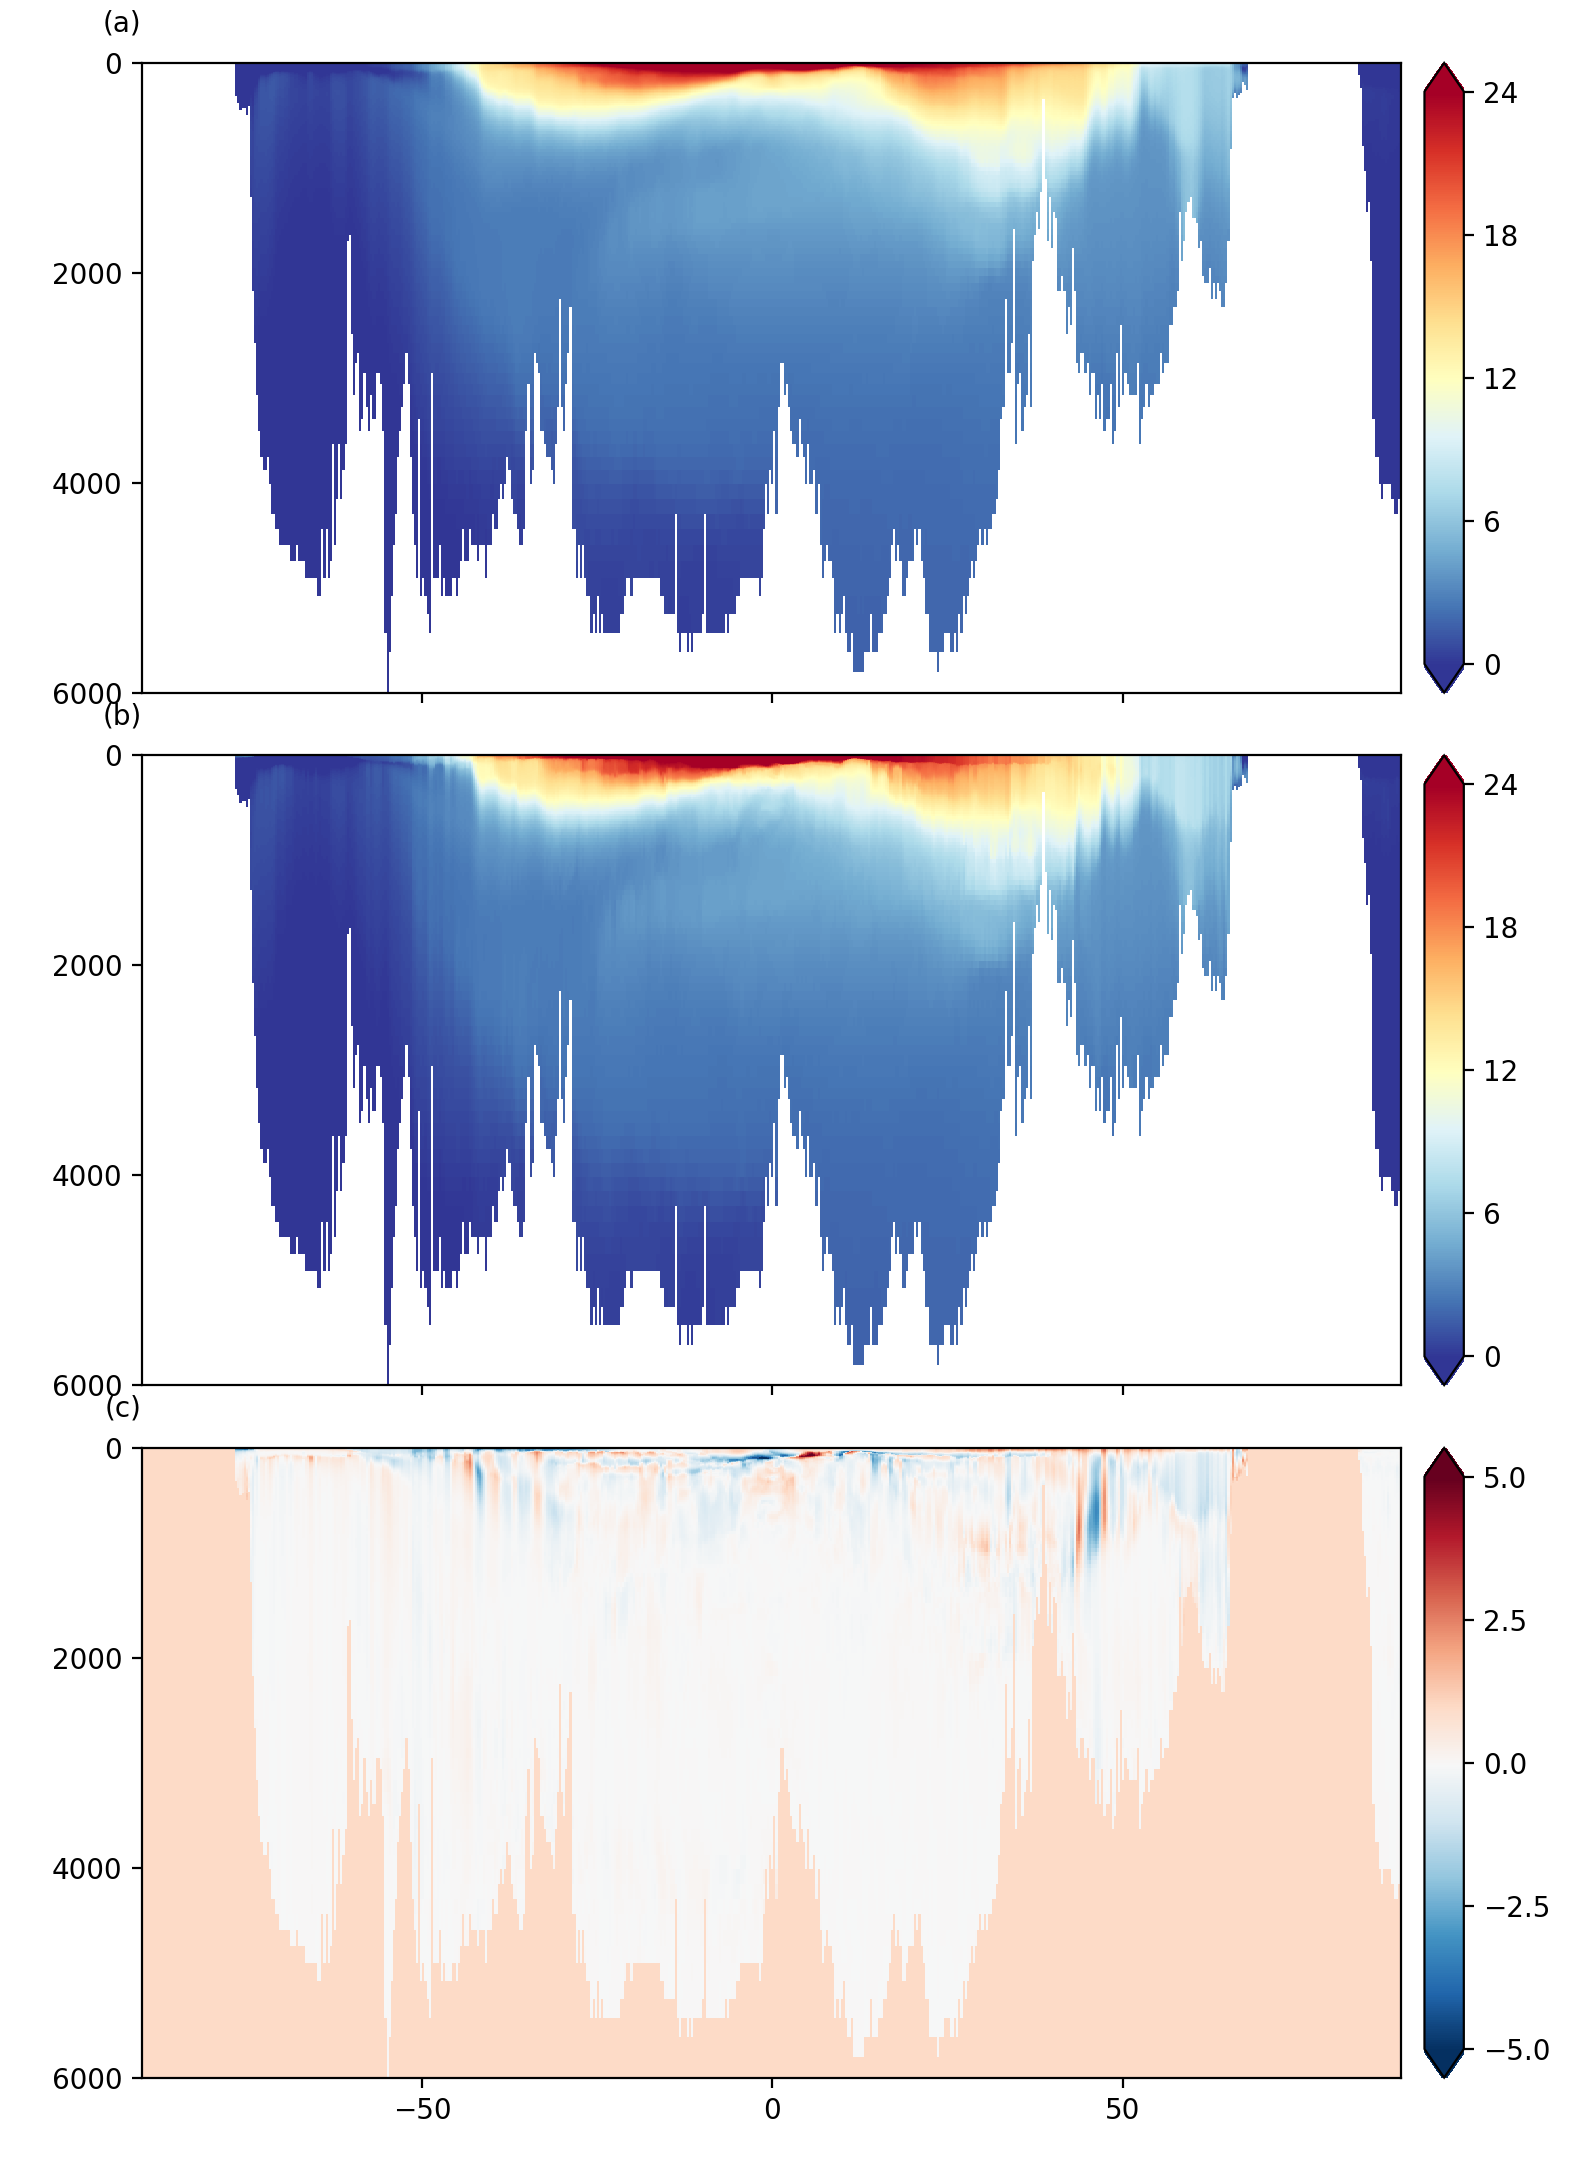

/work/mh0033/m300602/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/work/mh0033/m300602/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 16 s, sys: 40.4 s, total: 56.4 s
Wall time: 57.5 s


In [89]:
%%time
hca, hcb = pyic.arrange_axes(1, 3, asp=0.5, fig_size_fac=2, plot_cb=True, 
                             sharex=True, sharey=True,
                            )
ii=-1

lat = ds_icon.lat
lon = ds_icon.lon
depth = ds_icon.depth

ii+=1; ax=hca[ii]; cax=hcb[ii]
# data = ds_icon.toi[0,:,:,:].sel(lon=-30, method='nearest')
data = toi_mean[:,:,ix]
pyic.shade(lat, depth, data, ax=ax, cax=cax, clim=[0,24])

ii+=1; ax=hca[ii]; cax=hcb[ii]
# data = ds_ref.to_ref[0,:,:,:].sel(lon=-30, method='nearest')
data = to_ref[:,:,ix]
pyic.shade(lat, depth, data, ax=ax, cax=cax, clim=[0,24])

ii+=1; ax=hca[ii]; cax=hcb[ii]
# data = ds_icon.toi[0,:,:,:].sel(lon=-30, method='nearest')-ds_ref.to_ref[0,:,:,:].sel(lon=-30, method='nearest')
data = toi_mean[:,:,ix] - to_ref[:,:,ix]
pyic.shade(lat, depth, data, ax=ax, cax=cax, clim=5)

for ax in hca:              
    ax.set_ylim(6000,0)

In [90]:
%%time

toi = ds_icon['toi'][0,1,:,:].compute()#.data
soi = ds_icon['soi'][0,1,:,:].compute()#.data

toi_bias = (ds_icon['toi'][0,1,:,:] - (ds_ref['to_ref'][0,1,:,:])).compute()#.data
soi_bias = (ds_icon['soi'][0,1,:,:] - (ds_ref['so_ref'][0,1,:,:])).compute()#.data

CPU times: user 66 ms, sys: 49 ms, total: 115 ms
Wall time: 291 ms


In [43]:
ds_icon.toi[0,:,:,:].max().compute()#, ds_ref.to_ref[0,:,:,:].max()

<xarray.DataArray 'toi' ()>
array(32.8291626)
Coordinates:
    month    int64 1

In [76]:
%%time

fpath_icon_02 = f'{path_scratch}/dymwin_bias_plots_interp_icon_02.nc'
# if l_derive_data: # 5min 12sec
if True:
    print('bias')
    ds_icon['to_bias'] = ds_icon['to'] - ds_ref['to_ref']
    ds_icon['so_bias'] = ds_icon['so'] - ds_ref['so_ref']

    print('bias_zave')
    ds_icon['to_bias_zave'] = ds_icon['to_bias'].mean(dim='lon')
    ds_icon['so_bias_zave'] = ds_icon['so_bias'].mean(dim='lon')

    print('zave')
    ds_icon['to_zave'] = ds_icon['to'].mean(dim='lon')
    ds_icon['so_zave'] = ds_icon['so'].mean(dim='lon')
    ds_icon['uo_zave'] = ds_icon['ui'].mean(dim='lon')

    print('different basin biases')
    data = ds_icon['to_bias'].to_masked_array()
    data[:, :, basin_ci!=1] = np.ma.masked
    ds_icon['to_bias_azave'] = xr.DataArray(data.mean(axis=3), dims=['time', 'depth', 'lat'])

    data = ds_icon['to_bias'].to_masked_array()
    data[:, :, (basin_ci!=3)&(basin_ci!=7)] = np.ma.masked
    ds_icon['to_bias_ipzave'] = xr.DataArray(data.mean(axis=3), dims=['time', 'depth', 'lat'])

    data = ds_icon['so_bias'].to_masked_array()
    data[:, :, basin_ci!=1] = np.ma.masked
    ds_icon['so_bias_azave'] = xr.DataArray(data.mean(axis=3), dims=['time', 'depth', 'lat'])

    data = ds_icon['so_bias'].to_masked_array()
    data[:, :, (basin_ci!=3)&(basin_ci!=7)] = np.ma.masked
    ds_icon['so_bias_ipzave'] = xr.DataArray(data.mean(axis=3), dims=['time', 'depth', 'lat'])
    
#     print(f'Saving {fpath_icon_02}')
#     ds_icon.to_netcdf(fpath_icon_02)
else:
    print(f'Saving {fpath_icon_02}')
    ds_icon = xr.open_dataset(fpath_icon_02)

bias


IndexError: The indexing operation you are attempting to perform is not valid on netCDF4.Variable object. Try loading your data into memory first by calling .load().

## Start plotting

### Surface

sst


/work/mh0033/m300602/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


sst bias


/work/mh0033/m300602/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


sss


/work/mh0033/m300602/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


sss bias


/work/mh0033/m300602/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Saving /home/mpim/m300602/proj_dymwin/html/exp.ocean_era51h_zstar_r2b9_21249-DXB/pics//r2b9_dymwin_spinup_sst_sss.png


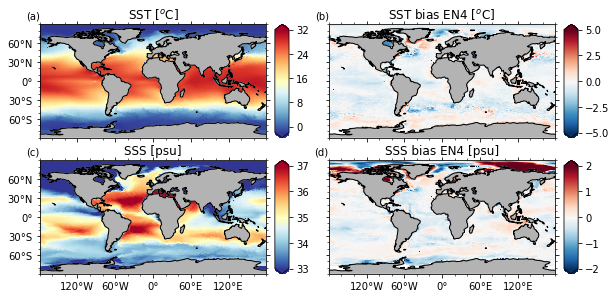

In [72]:
projection = ccrs.PlateCarree()
hca, hcb = pyic.arrange_axes(2, 2, asp=0.5, fig_size_fac=1, plot_cb=True, 
                             sharex=True, sharey=True, projection=projection,
                            )
ii=-1

print('sst')
ii+=1; ax=hca[ii]; cax=hcb[ii]
data = ds_icon.to.isel(depth=0).mean(dim='time')
pyic.shade(lon, lat, data, ax=ax, cax=cax, clim=[-2,32],
           projection=ccrs.PlateCarree())
ax.set_title('SST [$^o$C]')

print('sst bias')
ii+=1; ax=hca[ii]; cax=hcb[ii]
data = ds_icon.to.isel(depth=0).mean(dim='time') - ds_ref.to_ref.isel(depth=2).mean(dim='time')
pyic.shade(lon, lat, data, ax=ax, cax=cax, clim=5,
           projection=ccrs.PlateCarree())
ax.set_title('SST bias EN4 [$^o$C]')

print('sss')
ii+=1; ax=hca[ii]; cax=hcb[ii]
data = ds_icon.so.isel(depth=0).mean(dim='time')
pyic.shade(lon, lat, data, ax=ax, cax=cax, clim=[33,37],
           projection=ccrs.PlateCarree())
ax.set_title('SSS [psu]')

print('sss bias')
ii+=1; ax=hca[ii]; cax=hcb[ii]
data = ds_icon.so.isel(depth=0).mean(dim='time') - ds_ref.so_ref.isel(depth=2).mean(dim='time')
pyic.shade(lon, lat, data, ax=ax, cax=cax, clim=2,
           projection=ccrs.PlateCarree())
ax.set_title('SSS bias EN4 [psu]')

for ax in hca:
    pyic.plot_settings(ax=ax, template='global')

save_fig(f'{path_fig}/{thisscriptname}_sst_sss.png')

Saving /home/mpim/m300602/proj_dymwin/html/exp.ocean_era51h_zstar_r2b9_21249-DXB/pics//r2b9_dymwin_spinup_sst_bias.png
CPU times: user 15.7 s, sys: 189 ms, total: 15.9 s
Wall time: 15.9 s


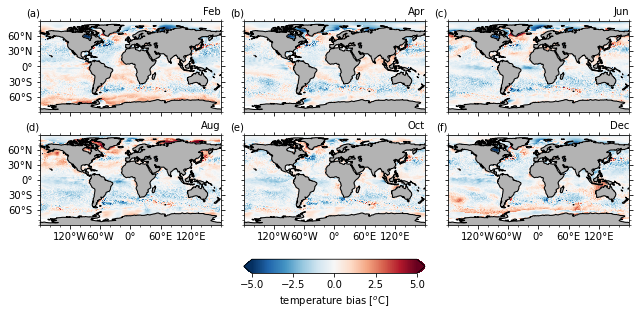

In [73]:
%%time
projection = ccrs.PlateCarree()
hca, hcb = pyic.arrange_axes(3, 2, asp=0.5, fig_size_fac=0.8, plot_cb='bottom', 
                             sharex=True, sharey=True, projection=projection,
                            )
ii=-1

for ll in range(1,12,2):
    print(f'll = {ll}', end='\r')
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    data = (ds_icon['to'][ll,0,:,:] - (ds_ref['to_ref'][ll,2,:,:]))
    pyic.shade(lon, lat, data, ax=ax, cax=cax, clim=5,
               projection=ccrs.PlateCarree())
#     ax.set_title('temperature bias')
    ax.set_title(f'{mstr[ll]}', loc='right', fontsize=10)
hcb[-1].set_xlabel('temperature bias [$^o$C]')

for ax in hca:
    pyic.plot_settings(ax, template='global')

save_fig(f'{path_fig}/{thisscriptname}_sst_bias.png')

Saving /home/mpim/m300602/proj_dymwin/html/exp.ocean_era51h_zstar_r2b9_21249-DXB/pics//r2b9_dymwin_spinup_sss_bias.png
CPU times: user 15.2 s, sys: 56 ms, total: 15.2 s
Wall time: 15.2 s


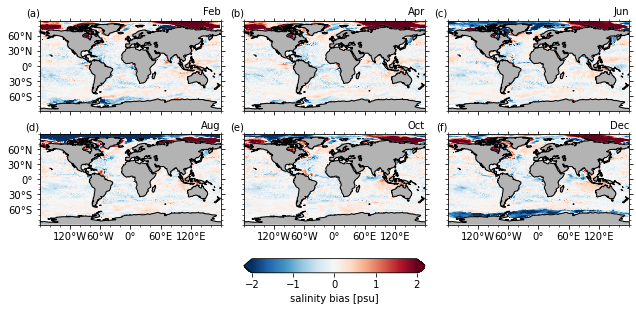

In [75]:
%%time
projection = ccrs.PlateCarree()
hca, hcb = pyic.arrange_axes(3, 2, asp=0.5, fig_size_fac=0.8, plot_cb='bottom', 
                             sharex=True, sharey=True, projection=projection,
                            )
ii=-1

for ll in range(1,12,2):
    print(f'll = {ll}', end='\r')
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    data = (ds_icon['so'][ll,0,:,:] - (ds_ref['so_ref'][ll,2,:,:]))
    pyic.shade(lon, lat, data, ax=ax, cax=cax, clim=2,
               projection=ccrs.PlateCarree())
#     ax.set_title('temperature bias')
    ax.set_title(f'{mstr[ll]}', loc='right', fontsize=10)
hcb[-1].set_xlabel('salinity bias [psu]')

for ax in hca:
    pyic.plot_settings(ax, template='global')

save_fig(f'{path_fig}/{thisscriptname}_sss_bias.png')

### Zonal averages

Saving /home/mpim/m300602/proj_dymwin/html/exp.ocean_era51h_zstar_r2b9_21249-DXB/pics//r2b9_dymwin_spinup_to_bias_zave.png
CPU times: user 1.27 s, sys: 32 ms, total: 1.3 s
Wall time: 2.38 s


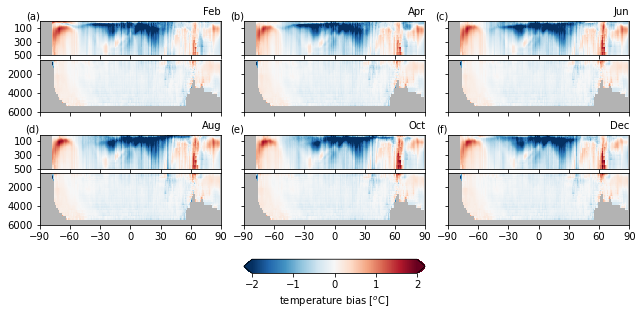

In [127]:
%%time
hca, hcb = pyic.arrange_axes(3, 2, asp=0.5, fig_size_fac=0.8, plot_cb='bottom', 
                             sharex=True, sharey=True,
                            )
ii=-1

for ll in range(1,12,2):
    print(f'll = {ll}', end='\r')
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    data = ds_icon['to_bias_zave'][ll,:,:]
    ax = pyic.split_axes_vertically(ax)
    hca[ii] = ax
    for axsp in ax.axs:
        pyic.shade(lat, depth, data, ax=axsp, cax=cax, clim=2)
    ax.set_title(f'{mstr[ll]}', loc='right', fontsize=10)
hcb[-1].set_xlabel('temperature bias [$^o$C]')

for ax in hca:
    ax.set_facecolor('0.7')
    ax.set_ylim([6000,500],[500,0])
    ax.set_xticks(np.arange(-90,100,30))
    ax.set_yticks([6000,4000,2000], [500,300,100])
    
save_fig(f'{path_fig}/{thisscriptname}_to_bias_zave.png')

Saving /home/mpim/m300602/proj_dymwin/html/exp.ocean_era51h_zstar_r2b9_21249-DXB/pics//r2b9_dymwin_spinup_to_bias_azave.png
CPU times: user 1.43 s, sys: 20 ms, total: 1.45 s
Wall time: 1.45 s


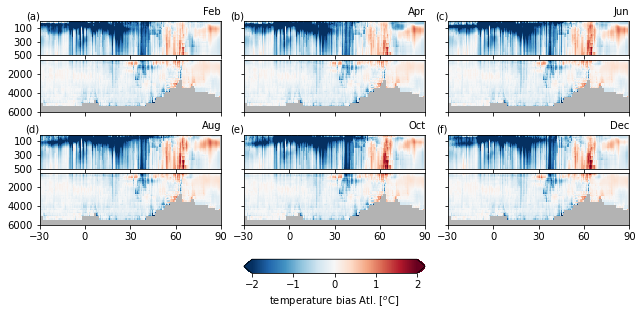

In [128]:
%%time
hca, hcb = pyic.arrange_axes(3, 2, asp=0.5, fig_size_fac=0.8, plot_cb='bottom', 
                             sharex=True, sharey=True,
                            )
ii=-1

for ll in range(1,12,2):
    print(f'll = {ll}', end='\r')
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    data = ds_icon['to_bias_azave'][ll,:,:]
    ax = pyic.split_axes_vertically(ax)
    hca[ii] = ax
    for axsp in ax.axs:
        pyic.shade(lat, depth, data, ax=axsp, cax=cax, clim=2)
    ax.set_title(f'{mstr[ll]}', loc='right', fontsize=10)
hcb[-1].set_xlabel('temperature bias Atl. [$^o$C]')

for ax in hca:
    ax.set_facecolor('0.7')
    ax.set_ylim([6000,500],[500,0])
    ax.set_xticks(np.arange(-30,100,30))
    ax.set_xlim(-30,90)
    ax.set_yticks([6000,4000,2000], [500,300,100])
    
save_fig(f'{path_fig}/{thisscriptname}_to_bias_azave.png')

Saving /home/mpim/m300602/proj_dymwin/html/exp.ocean_era51h_zstar_r2b9_21249-DXB/pics//r2b9_dymwin_spinup_so_bias_zave.png
CPU times: user 1.51 s, sys: 12 ms, total: 1.52 s
Wall time: 1.51 s


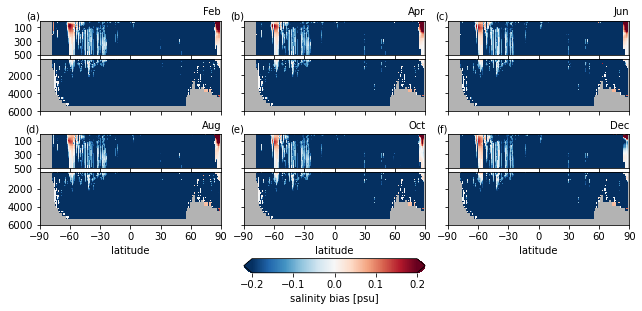

In [129]:
%%time
hca, hcb = pyic.arrange_axes(3, 2, asp=0.5, fig_size_fac=0.8, plot_cb='bottom', 
                             sharex=True, sharey=True, xlabel='latitude',
                            )
ii=-1

for ll in range(1,12,2):
    print(f'll = {ll}', end='\r')
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    data = ds_icon['so_bias_zave'][ll,:,:]
    ax = pyic.split_axes_vertically(ax)
    hca[ii] = ax
    for axsp in ax.axs:
        pyic.shade(lat, depth, data, ax=axsp, cax=cax, clim=0.2)
    ax.set_title(f'{mstr[ll]}', loc='right', fontsize=10)
hcb[-1].set_xlabel('salinity bias [psu]')

for ax in hca:
    ax.set_facecolor('0.7')
    ax.set_ylim([6000,200],[200,0])
    ax.set_xticks(np.arange(-90,100,30))
    ax.set_yticks([6000,4000,2000], [500,300,100])

save_fig(f'{path_fig}/{thisscriptname}_so_bias_zave.png')

### Equatorial region

In [130]:
j0 = np.argmin(lat**2)

Saving /home/mpim/m300602/proj_dymwin/html/exp.ocean_era51h_zstar_r2b9_21249-DXB/pics//r2b9_dymwin_spinup_to_bias_eq_along_sec.png
CPU times: user 1.96 s, sys: 52 ms, total: 2.01 s
Wall time: 2.82 s


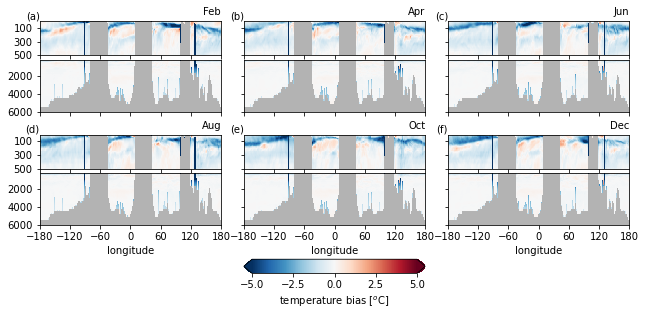

In [131]:
%%time
hca, hcb = pyic.arrange_axes(3, 2, asp=0.5, fig_size_fac=0.8, plot_cb='bottom', 
                             sharex=True, sharey=True, xlabel='longitude',
                            )
ii=-1

for ll in range(1,12,2):
    print(f'll = {ll}', end='\r')
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    data = ds_icon['to_bias'][ll,:,j0,:]
    ax = pyic.split_axes_vertically(ax)
    hca[ii] = ax
    for axsp in ax.axs:
        pyic.shade(lon, depth, data, ax=axsp, cax=cax, clim=5)
    ax.set_title(f'{mstr[ll]}', loc='right', fontsize=10)
hcb[-1].set_xlabel('temperature bias [$^o$C]')

for ax in hca:
    ax.set_facecolor('0.7')
    ax.set_ylim([6000,200],[200,0])
    ax.set_xticks(np.arange(-180,190,60))
    ax.set_yticks([6000,4000,2000], [500,300,100])
    
save_fig(f'{path_fig}/{thisscriptname}_to_bias_eq_along_sec.png')

Saving /home/mpim/m300602/proj_dymwin/html/exp.ocean_era51h_zstar_r2b9_21249-DXB/pics//r2b9_dymwin_spinup_uo_eq_across.png
CPU times: user 824 ms, sys: 33 ms, total: 857 ms
Wall time: 2.09 s


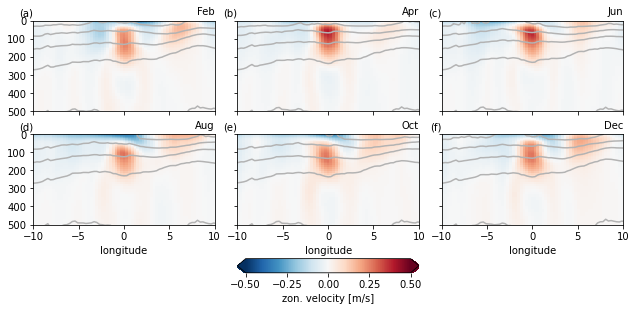

In [138]:
%%time
hca, hcb = pyic.arrange_axes(3, 2, asp=0.5, fig_size_fac=0.8, plot_cb='bottom', 
                             sharex=True, sharey=True, xlabel='longitude',
                            )
ii=-1

for ll in range(1,12,2):
    print(f'll = {ll}', end='\r')
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    data = ds_icon['uo_zave'][ll,:,:]
    pyic.shade(lat, depth, data, ax=ax, cax=cax, clim=0.5)
    ax.contour(lat, depth, ds_icon['to_zave'][ll,:,:], np.arange(-2,32,4), colors='0.7')
    ax.set_title(f'{mstr[ll]}', loc='right', fontsize=10)
hcb[-1].set_xlabel('zon. velocity [m/s]')

for ax in hca:
    ax.set_facecolor('0.7')
    ax.set_ylim(500,0)
    ax.set_xlim(-10,10)
    
save_fig(f'{path_fig}/{thisscriptname}_uo_eq_across.png')

Saving /home/mpim/m300602/proj_dymwin/html/exp.ocean_era51h_zstar_r2b9_21249-DXB/pics//r2b9_dymwin_spinup_to_bias_eq_across.png
CPU times: user 1.42 s, sys: 19 ms, total: 1.44 s
Wall time: 1.44 s


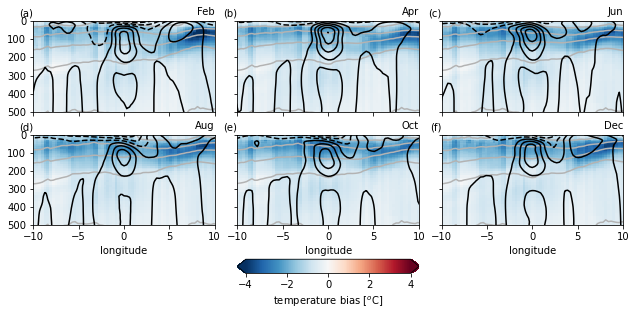

In [139]:
%%time
hca, hcb = pyic.arrange_axes(3, 2, asp=0.5, fig_size_fac=0.8, plot_cb='bottom', 
                             sharex=True, sharey=True, xlabel='longitude',
                            )
ii=-1

for ll in range(1,12,2):
    print(f'll = {ll}', end='\r')
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    data = ds_icon['to_bias_zave'][ll,:,:]
    pyic.shade(lat, depth, data, ax=ax, cax=cax, clim=4.)
    ax.contour(lat, depth, ds_icon['to_zave'][ll,:,:], np.arange(-2,32,4), colors='0.7')
    ax.contour(lat, depth, ds_icon['uo_zave'][ll,:,:], np.arange(-2.,2.,0.1), colors='k')
    ax.set_title(f'{mstr[ll]}', loc='right', fontsize=10)
hcb[-1].set_xlabel('temperature bias [$^o$C]')

for ax in hca:
    ax.set_facecolor('0.7')
    ax.set_ylim(500,0)
    ax.set_xlim(-10,10)
    
save_fig(f'{path_fig}/{thisscriptname}_to_bias_eq_across.png')

### SSH

Saving /home/mpim/m300602/proj_dymwin/html/exp.ocean_era51h_zstar_r2b9_21249-DXB/pics//r2b9_dymwin_spinup_ssh.png
CPU times: user 15.3 s, sys: 352 ms, total: 15.7 s
Wall time: 16 s


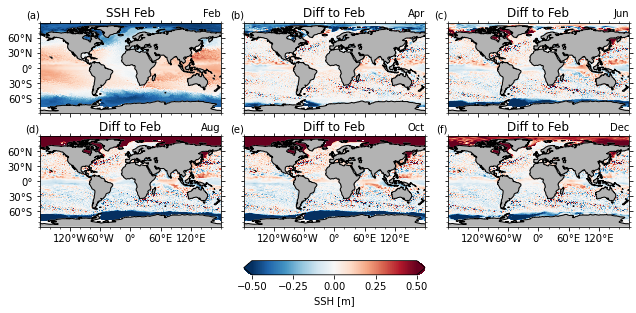

In [141]:
%%time
projection = ccrs.PlateCarree()
hca, hcb = pyic.arrange_axes(3, 2, asp=0.5, fig_size_fac=0.8, plot_cb='bottom', 
                             sharex=True, sharey=True, projection=projection,
                            )
ii=-1

data_ref = ds_icon['zos'][1,:,:]

for ll in range(1,12,2):
    print(f'll = {ll}', end='\r')
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    if ll==1:
        data = ds_icon['zos'][ll,:,:]
        ax.set_title('SSH Feb')
        clim = 2
    else:
        data = ds_icon['zos'][ll,:,:] - data_ref
        ax.set_title('Diff to Feb')
        clim = 0.5
    
    pyic.shade(lon, lat, data, ax=ax, cax=cax, clim=clim,
               projection=ccrs.PlateCarree())
    ax.set_title(f'{mstr[ll]}', loc='right', fontsize=10)
hcb[-1].set_xlabel('SSH [m]')

for ax in hca:
    pyic.plot_settings(ax, template='global')

save_fig(f'{path_fig}/{thisscriptname}_ssh.png')

### Ice

Saving /home/mpim/m300602/proj_dymwin/html/exp.ocean_era51h_zstar_r2b9_21249-DXB/pics//r2b9_dymwin_spinup_ice_concentration_nh.png
CPU times: user 11 s, sys: 1.11 s, total: 12.1 s
Wall time: 10.7 s


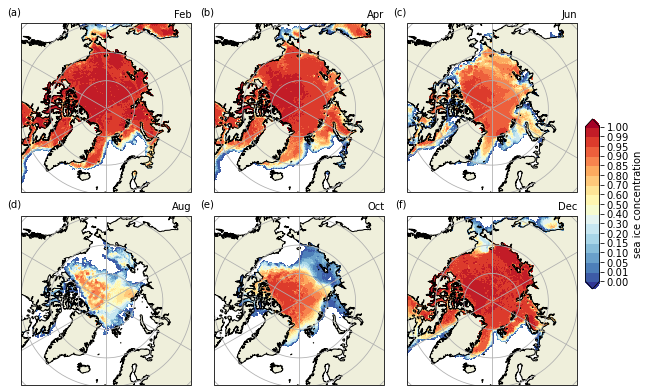

In [150]:
%%time
projection = ccrs.PlateCarree()
hca, hcb = pyic.arrange_axes(3, 2, asp=1., fig_size_fac=1.5, plot_cb='right', 
                             sharex=True, sharey=True, projection=ccrs.NorthPolarStereo(),
                            )
ii=-1

data = (ds_icon.conc.isel(lev=0)).compute()
data = data.where(data!=0)

for ll in range(1,12,2):
    print(f'll = {ll}', end='\r')
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    clim=[0,1]
    clevs=np.array([0,1.,5,10,15,20,30,40,50,60,70,80,85,90,95,99,100])/100.
    pyic.shade(lon, lat, data[ll,:,:], ax=ax, cax=cax, clim=clim, clevs=clevs,
               projection=ccrs.PlateCarree())
    ax.set_title(f'{mstr[ll]}', loc='right', fontsize=10)
hcb[-1].set_ylabel('sea ice concentration')

for ax in hca:
    ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    ax.gridlines()
    ax.add_feature(cartopy.feature.LAND)
    ax.coastlines()

save_fig(f'{path_fig}/{thisscriptname}_ice_concentration_nh.png')

Saving /home/mpim/m300602/proj_dymwin/html/exp.ocean_era51h_zstar_r2b9_21249-DXB/pics//r2b9_dymwin_spinup_ice_thickness_nh.png
CPU times: user 11 s, sys: 1.33 s, total: 12.4 s
Wall time: 11 s


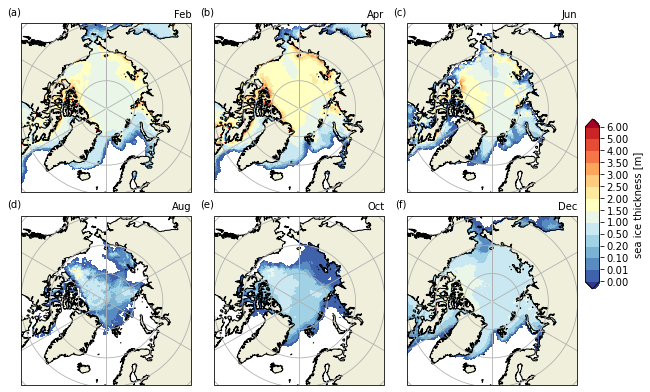

In [151]:
%%time
projection = ccrs.PlateCarree()
hca, hcb = pyic.arrange_axes(3, 2, asp=1., fig_size_fac=1.5, plot_cb='right', 
                             sharex=True, sharey=True, projection=ccrs.NorthPolarStereo(),
                            )
ii=-1

data = (ds_icon.hi*ds_icon.conc).isel(lev=0).compute()
data = data.where(data!=0)

for ll in range(1,12,2):
    print(f'll = {ll}', end='\r')
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    clim=[0,6]
    clevs=[0, 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 6]
    pyic.shade(lon, lat, data[ll,:,:], ax=ax, cax=cax, clim=clim, clevs=clevs,
               projection=ccrs.PlateCarree())
    ax.set_title(f'{mstr[ll]}', loc='right', fontsize=10)
hcb[-1].set_ylabel('sea ice thickness [m]')

for ax in hca:
    ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    ax.gridlines()
    ax.add_feature(cartopy.feature.LAND)
    ax.coastlines()

save_fig(f'{path_fig}/{thisscriptname}_ice_thickness_nh.png')

Saving /home/mpim/m300602/proj_dymwin/html/exp.ocean_era51h_zstar_r2b9_21249-DXB/pics//r2b9_dymwin_spinup_ice_concentration_sh.png
CPU times: user 1min 41s, sys: 1.29 s, total: 1min 42s
Wall time: 1min 41s


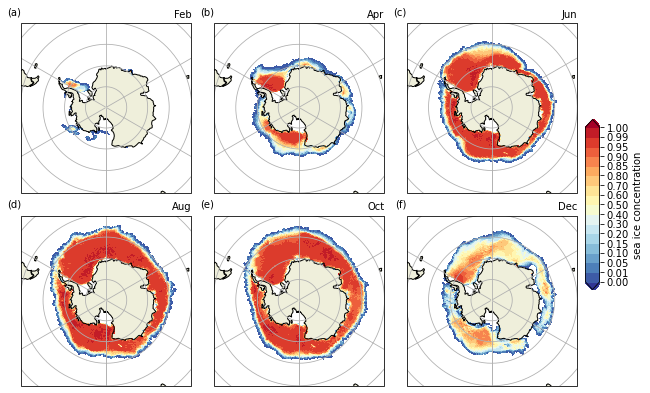

In [153]:
%%time
projection = ccrs.PlateCarree()
hca, hcb = pyic.arrange_axes(3, 2, asp=1., fig_size_fac=1.5, plot_cb='right', 
                             sharex=True, sharey=True, projection=ccrs.SouthPolarStereo(),
                            )
ii=-1

data = (ds_icon.conc).isel(lev=0).compute()
data = data.where(data!=0)

for ll in range(1,12,2):
    print(f'll = {ll}', end='\r')
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    clim=[0,1]
    clevs=np.array([0,1.,5,10,15,20,30,40,50,60,70,80,85,90,95,99,100])/100.
    pyic.shade(lon, lat, data[ll,:,:], ax=ax, cax=cax, clim=clim, clevs=clevs,
               projection=ccrs.PlateCarree())
    ax.set_title(f'{mstr[ll]}', loc='right', fontsize=10)
hcb[-1].set_ylabel('sea ice concentration')

for ax in hca:
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    ax.gridlines()
    ax.add_feature(cartopy.feature.LAND)
    ax.coastlines()

save_fig(f'{path_fig}/{thisscriptname}_ice_concentration_sh.png')

Saving /home/mpim/m300602/proj_dymwin/html/exp.ocean_era51h_zstar_r2b9_21249-DXB/pics//r2b9_dymwin_spinup_ice_thickness_sh.png
CPU times: user 1min 38s, sys: 1.15 s, total: 1min 39s
Wall time: 1min 37s


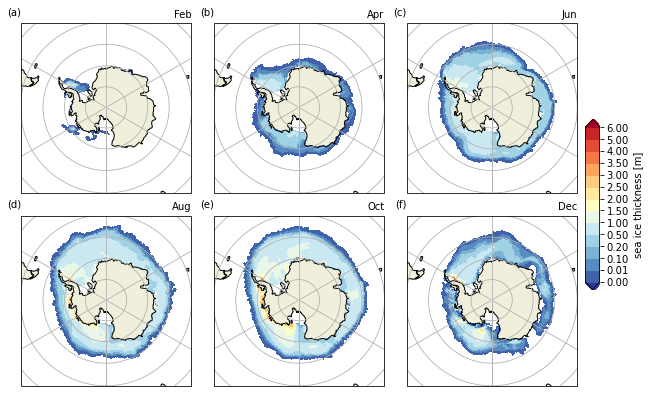

In [154]:
%%time
projection = ccrs.PlateCarree()
hca, hcb = pyic.arrange_axes(3, 2, asp=1., fig_size_fac=1.5, plot_cb='right', 
                             sharex=True, sharey=True, projection=ccrs.SouthPolarStereo(),
                            )
ii=-1

data = (ds_icon.hi*ds_icon.conc).isel(lev=0).compute()
data = data.where(data!=0)

for ll in range(1,12,2):
    print(f'll = {ll}', end='\r')
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    clim=[0,6]
    clevs=[0, 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 6]
    pyic.shade(lon, lat, data[ll,:,:], ax=ax, cax=cax, clim=clim, clevs=clevs,
               projection=ccrs.PlateCarree())
    ax.set_title(f'{mstr[ll]}', loc='right', fontsize=10)
hcb[-1].set_ylabel('sea ice thickness [m]')

for ax in hca:
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    ax.gridlines()
    ax.add_feature(cartopy.feature.LAND)
    ax.coastlines()

save_fig(f'{path_fig}/{thisscriptname}_ice_thickness_sh.png')